group testing: 3.3007000000750963e-05
93
50
Epoch 0 - Training loss: 2.291980743408203
Epoch 0 - Test loss: 2.27538800239563
Epoch 1 - Training loss: 2.251885414123535
Epoch 1 - Test loss: 2.2254629135131836
Epoch 2 - Training loss: 2.1822290420532227
Epoch 2 - Test loss: 2.1356260776519775
Epoch 3 - Training loss: 2.0685875415802
Epoch 3 - Test loss: 2.0056912899017334
Epoch 4 - Training loss: 1.9273205995559692
Epoch 4 - Test loss: 1.8649367094039917
Epoch 5 - Training loss: 1.7891353368759155
Epoch 5 - Test loss: 1.737169623374939
Epoch 6 - Training loss: 1.6686331033706665
Epoch 6 - Test loss: 1.6276915073394775
Epoch 7 - Training loss: 1.567644476890564
Epoch 7 - Test loss: 1.5354024171829224
Epoch 8 - Training loss: 1.483883261680603
Epoch 8 - Test loss: 1.4578198194503784
Epoch 9 - Training loss: 1.4141833782196045
Epoch 9 - Test loss: 1.392472743988037
Epoch 10 - Training loss: 1.3891226053237915
Epoch 10 - Test loss: 1.3504486083984375
Epoch 11 - Training loss: 1.3443540334701

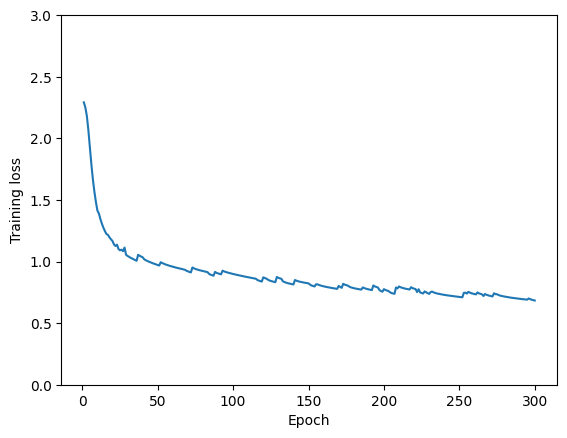

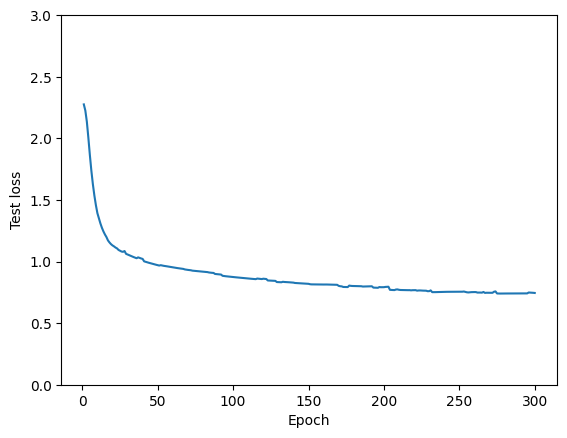

In [1]:
EPOCHS = 300
SUBSET_UPDATE_PROB = 0.2
PADDING_METHOD = "latest"
LEARNING_RATE = 0.1
GROUP_TESTING_ROUNDS = 5
res = []

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import syft as sy
import random
from time import process_time

from src.psi.util import Client, Server
from src.discrete_splitnn import DiscreteSplitNN
from src.utils import add_ids
from src.discrete_distribute_data import DiscreteDistributeMNIST

hook = sy.TorchHook(torch)

# Data preprocessing
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('mnist', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64
                                          , shuffle=True)

# create some workers
client_1 = sy.VirtualWorker(hook, id="client_1")
client_2 = sy.VirtualWorker(hook, id="client_2")
client_3 = sy.VirtualWorker(hook, id="client_3")
client_4 = sy.VirtualWorker(hook, id="client_4")
server = sy.VirtualWorker(hook, id= "server") 

data_owners = (client_1, client_2, client_3, client_4)
model_locations = [client_1, client_2, client_3, client_4, server]

#Split each image and send one part to client_1, and other to client_2
distributed_trainloader = DiscreteDistributeMNIST(data_owners=data_owners, data_loader=trainloader)

torch.manual_seed(0)

# Define our model segments

input_size= [28*7, 28*7, 28*7, 28*7]
hidden_sizes= {"client_1": [16, 32], "client_2":[16, 32], "client_3": [16, 32], "client_4":[16, 32], "server":[128, 64]}
output_size = 10

models = {
    "client_1": nn.Sequential(
                nn.Linear(input_size[0], hidden_sizes["client_1"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_1"][0], hidden_sizes["client_1"][1]),
                nn.ReLU(),
    ),
    "client_2":  nn.Sequential(
                nn.Linear(input_size[1], hidden_sizes["client_2"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_2"][0], hidden_sizes["client_2"][1]),
                nn.ReLU(),
    ),
    "client_3":  nn.Sequential(
                nn.Linear(input_size[2], hidden_sizes["client_3"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_3"][0], hidden_sizes["client_3"][1]),
                nn.ReLU(),
    ),
    "client_4":  nn.Sequential(
                nn.Linear(input_size[3], hidden_sizes["client_4"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_4"][0], hidden_sizes["client_4"][1]),
                nn.ReLU(),
    ),
    "server": nn.Sequential(
                nn.Linear(hidden_sizes["server"][0], hidden_sizes["server"][1]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["server"][1], 10),
                nn.LogSoftmax(dim=1)
    )
}

# Create optimisers for each segment and link to them
optimizers = [
    (optim.SGD(models[location.id].parameters(), lr=LEARNING_RATE,), location)
    for location in model_locations
]

for location in model_locations:
    models[location.id].send(location)


#Instantiate a SpliNN class with our distributed segments and their respective optimizers
splitNN = DiscreteSplitNN(models, server, data_owners, optimizers, distributed_trainloader, k=10, n_selected=2, padding_method=PADDING_METHOD)

distributed_trainloader.generate_subdata()
s = process_time()
#splitNN.group_testing(GROUP_TESTING_ROUNDS)
print('group testing: ' + str(process_time() - s))
splitNN.selected['client_1'] = False
splitNN.selected['client_2'] = True
splitNN.selected['client_3'] = True
splitNN.selected['client_4'] = False

test_perf = []
performance = []
print(len(distributed_trainloader.distributed_subdata))
print(len(distributed_trainloader.test_set))
for i in range(EPOCHS):
    s = process_time()
    if (i > 0) and (i % 300 == 0):
        plt.plot(range(1, i+1), performance)
        plt.ylabel('Training loss')
        plt.xlabel('Epoch')
        plt.ylim([0,3])
        plt.show()

        plt.plot(range(1, i+1), test_perf)
        plt.ylabel('Test loss')
        plt.xlabel('Epoch')
        plt.ylim([0,3])
        plt.show()
    running_loss = 0
    test_loss = 0
    if (random.random() < SUBSET_UPDATE_PROB):
        distributed_trainloader.generate_subdata()
        #splitNN.group_testing(GROUP_TESTING_ROUNDS)
    
    #iterate over each datapoint 
    for _, data_ptr, label in distributed_trainloader.distributed_subdata:
        
        #send labels to server's location for training
        label = label.send(server)
        
        loss = splitNN.train(data_ptr, label)
        running_loss += loss
    
    for data_ptr, label in distributed_trainloader.test_set:
        label = label.send(server)
        
        loss = splitNN.eval(data_ptr, label)
        test_loss += loss
    
    test_perf.append((test_loss/len(distributed_trainloader.test_set)).item())
    performance.append((running_loss/len(distributed_trainloader.distributed_subdata)).item())
    print("Epoch {} - Training loss: {}".format(i, running_loss/len(distributed_trainloader.distributed_subdata)))
    print("Epoch {} - Test loss: {}".format(i, test_loss/len(distributed_trainloader.test_set)))


print(performance)
res.append(performance)
plt.plot(range(1, EPOCHS+1), performance)
plt.ylabel('Training loss')
plt.xlabel('Epoch')
plt.ylim([0,3])
plt.show()

plt.plot(range(1, EPOCHS+1), test_perf)
plt.ylabel('Test loss')
plt.xlabel('Epoch')
plt.ylim([0,3])
plt.show()



group testing: 3.678800021589268e-05
81
50
Epoch 0 - Training loss: 2.2985477447509766
Epoch 0 - Test loss: 2.2932474613189697
Epoch 1 - Training loss: 2.286067008972168
Epoch 1 - Test loss: 2.2821974754333496
Epoch 2 - Training loss: 2.2703278064727783
Epoch 2 - Test loss: 2.2640740871429443
Epoch 3 - Training loss: 2.2459208965301514
Epoch 3 - Test loss: 2.2356321811676025
Epoch 4 - Training loss: 2.210156202316284
Epoch 4 - Test loss: 2.196556806564331
Epoch 5 - Training loss: 2.1642613410949707
Epoch 5 - Test loss: 2.149898052215576
Epoch 6 - Training loss: 2.113215446472168
Epoch 6 - Test loss: 2.1014997959136963
Epoch 7 - Training loss: 2.0623223781585693
Epoch 7 - Test loss: 2.0547139644622803
Epoch 8 - Training loss: 2.019592523574829
Epoch 8 - Test loss: 2.0100886821746826
Epoch 9 - Training loss: 1.9701026678085327
Epoch 9 - Test loss: 1.960646629333496
Epoch 10 - Training loss: 1.9188523292541504
Epoch 10 - Test loss: 1.9107284545898438
Epoch 11 - Training loss: 1.8668171167

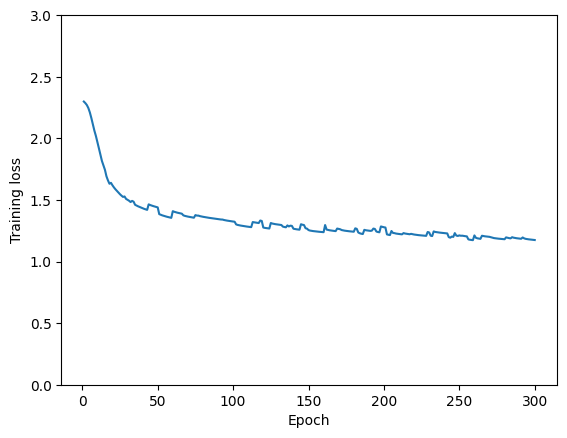

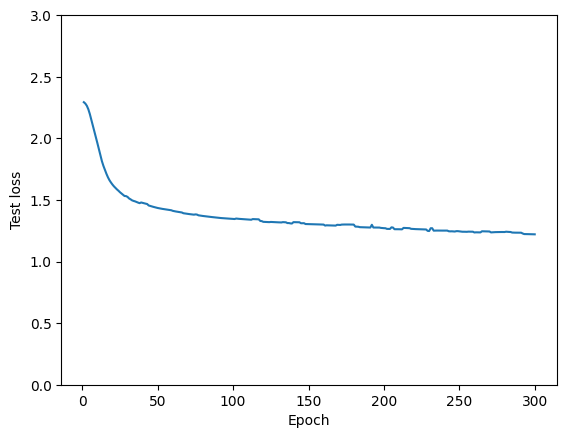

In [4]:
EPOCHS = 300
SUBSET_UPDATE_PROB = 0.2
PADDING_METHOD = "latest"
LEARNING_RATE = 0.1
GROUP_TESTING_ROUNDS = 5
res = []

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import syft as sy
import random
from time import process_time

from src.psi.util import Client, Server
from src.discrete_splitnn import DiscreteSplitNN
from src.utils import add_ids
from src.discrete_distribute_data import DiscreteDistributeMNIST

hook = sy.TorchHook(torch)

# Data preprocessing
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('mnist', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64
                                          , shuffle=True)

# create some workers
client_1 = sy.VirtualWorker(hook, id="client_1")
client_2 = sy.VirtualWorker(hook, id="client_2")
client_3 = sy.VirtualWorker(hook, id="client_3")
client_4 = sy.VirtualWorker(hook, id="client_4")
server = sy.VirtualWorker(hook, id= "server") 

data_owners = (client_1, client_2, client_3, client_4)
model_locations = [client_1, client_2, client_3, client_4, server]

#Split each image and send one part to client_1, and other to client_2
distributed_trainloader = DiscreteDistributeMNIST(data_owners=data_owners, data_loader=trainloader)

torch.manual_seed(0)

# Define our model segments

input_size= [28*7, 28*7, 28*7, 28*7]
hidden_sizes= {"client_1": [16, 32], "client_2":[16, 32], "client_3": [16, 32], "client_4":[16, 32], "server":[128, 64]}
output_size = 10

models = {
    "client_1": nn.Sequential(
                nn.Linear(input_size[0], hidden_sizes["client_1"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_1"][0], hidden_sizes["client_1"][1]),
                nn.ReLU(),
    ),
    "client_2":  nn.Sequential(
                nn.Linear(input_size[1], hidden_sizes["client_2"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_2"][0], hidden_sizes["client_2"][1]),
                nn.ReLU(),
    ),
    "client_3":  nn.Sequential(
                nn.Linear(input_size[2], hidden_sizes["client_3"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_3"][0], hidden_sizes["client_3"][1]),
                nn.ReLU(),
    ),
    "client_4":  nn.Sequential(
                nn.Linear(input_size[3], hidden_sizes["client_4"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_4"][0], hidden_sizes["client_4"][1]),
                nn.ReLU(),
    ),
    "server": nn.Sequential(
                nn.Linear(hidden_sizes["server"][0], hidden_sizes["server"][1]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["server"][1], 10),
                nn.LogSoftmax(dim=1)
    )
}

# Create optimisers for each segment and link to them
optimizers = [
    (optim.SGD(models[location.id].parameters(), lr=LEARNING_RATE,), location)
    for location in model_locations
]

for location in model_locations:
    models[location.id].send(location)


#Instantiate a SpliNN class with our distributed segments and their respective optimizers
splitNN = DiscreteSplitNN(models, server, data_owners, optimizers, distributed_trainloader, k=10, n_selected=2, padding_method=PADDING_METHOD)

distributed_trainloader.generate_subdata()
s = process_time()
#splitNN.group_testing(GROUP_TESTING_ROUNDS)
print('group testing: ' + str(process_time() - s))
splitNN.selected['client_1'] = False
splitNN.selected['client_2'] = True
splitNN.selected['client_3'] = False
splitNN.selected['client_4'] = False

test_perf = []
performance = []
print(len(distributed_trainloader.distributed_subdata))
print(len(distributed_trainloader.test_set))
for i in range(EPOCHS):
    s = process_time()
    if (i > 0) and (i % 300 == 0):
        plt.plot(range(1, i+1), performance)
        plt.ylabel('Training loss')
        plt.xlabel('Epoch')
        plt.ylim([0,3])
        plt.show()

        plt.plot(range(1, i+1), test_perf)
        plt.ylabel('Test loss')
        plt.xlabel('Epoch')
        plt.ylim([0,3])
        plt.show()
    running_loss = 0
    test_loss = 0
    if (random.random() < SUBSET_UPDATE_PROB):
        distributed_trainloader.generate_subdata()
        #splitNN.group_testing(GROUP_TESTING_ROUNDS)
    
    #iterate over each datapoint 
    for _, data_ptr, label in distributed_trainloader.distributed_subdata:
        
        #send labels to server's location for training
        label = label.send(server)
        
        loss = splitNN.train(data_ptr, label)
        running_loss += loss
    
    for data_ptr, label in distributed_trainloader.test_set:
        label = label.send(server)
        
        loss = splitNN.eval(data_ptr, label)
        test_loss += loss
    
    test_perf.append((test_loss/len(distributed_trainloader.test_set)).item())
    performance.append((running_loss/len(distributed_trainloader.distributed_subdata)).item())
    print("Epoch {} - Training loss: {}".format(i, running_loss/len(distributed_trainloader.distributed_subdata)))
    print("Epoch {} - Test loss: {}".format(i, test_loss/len(distributed_trainloader.test_set)))

print(performance)
res.append(performance)
plt.plot(range(1, EPOCHS+1), performance)
plt.ylabel('Training loss')
plt.xlabel('Epoch')
plt.ylim([0,3])
plt.show()

plt.plot(range(1, EPOCHS+1), test_perf)
plt.ylabel('Test loss')
plt.xlabel('Epoch')
plt.ylim([0,3])
plt.show()



group testing: 3.36560005962383e-05
91
50
Epoch 0 - Training loss: 2.2964890003204346
Epoch 0 - Test loss: 2.2853777408599854
Epoch 1 - Training loss: 2.2725841999053955
Epoch 1 - Test loss: 2.259044885635376
Epoch 2 - Training loss: 2.237407684326172
Epoch 2 - Test loss: 2.2156646251678467
Epoch 3 - Training loss: 2.1739046573638916
Epoch 3 - Test loss: 2.14212703704834
Epoch 4 - Training loss: 2.0884249210357666
Epoch 4 - Test loss: 2.0615041255950928
Epoch 5 - Training loss: 2.018509864807129
Epoch 5 - Test loss: 1.994309902191162
Epoch 6 - Training loss: 1.9536134004592896
Epoch 6 - Test loss: 1.9399785995483398
Epoch 7 - Training loss: 1.9011753797531128
Epoch 7 - Test loss: 1.8962632417678833
Epoch 8 - Training loss: 1.8582446575164795
Epoch 8 - Test loss: 1.8606572151184082
Epoch 9 - Training loss: 1.8228408098220825
Epoch 9 - Test loss: 1.8316348791122437
Epoch 10 - Training loss: 1.7938785552978516
Epoch 10 - Test loss: 1.8081517219543457
Epoch 11 - Training loss: 1.7701478004

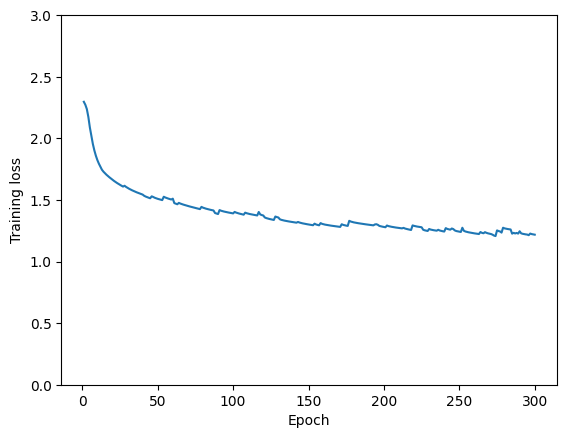

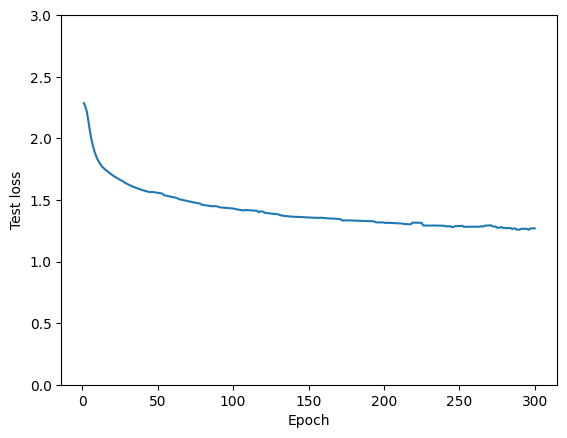

In [3]:
EPOCHS = 300
SUBSET_UPDATE_PROB = 0.2
PADDING_METHOD = "latest"
LEARNING_RATE = 0.1
GROUP_TESTING_ROUNDS = 5
res = []

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import syft as sy
import random
from time import process_time

from src.psi.util import Client, Server
from src.discrete_splitnn import DiscreteSplitNN
from src.utils import add_ids
from src.discrete_distribute_data import DiscreteDistributeMNIST

hook = sy.TorchHook(torch)

# Data preprocessing
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('mnist', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64
                                          , shuffle=True)

# create some workers
client_1 = sy.VirtualWorker(hook, id="client_1")
client_2 = sy.VirtualWorker(hook, id="client_2")
client_3 = sy.VirtualWorker(hook, id="client_3")
client_4 = sy.VirtualWorker(hook, id="client_4")
server = sy.VirtualWorker(hook, id= "server") 

data_owners = (client_1, client_2, client_3, client_4)
model_locations = [client_1, client_2, client_3, client_4, server]

#Split each image and send one part to client_1, and other to client_2
distributed_trainloader = DiscreteDistributeMNIST(data_owners=data_owners, data_loader=trainloader)

torch.manual_seed(0)

# Define our model segments

input_size= [28*7, 28*7, 28*7, 28*7]
hidden_sizes= {"client_1": [16, 32], "client_2":[16, 32], "client_3": [16, 32], "client_4":[16, 32], "server":[128, 64]}
output_size = 10

models = {
    "client_1": nn.Sequential(
                nn.Linear(input_size[0], hidden_sizes["client_1"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_1"][0], hidden_sizes["client_1"][1]),
                nn.ReLU(),
    ),
    "client_2":  nn.Sequential(
                nn.Linear(input_size[1], hidden_sizes["client_2"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_2"][0], hidden_sizes["client_2"][1]),
                nn.ReLU(),
    ),
    "client_3":  nn.Sequential(
                nn.Linear(input_size[2], hidden_sizes["client_3"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_3"][0], hidden_sizes["client_3"][1]),
                nn.ReLU(),
    ),
    "client_4":  nn.Sequential(
                nn.Linear(input_size[3], hidden_sizes["client_4"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_4"][0], hidden_sizes["client_4"][1]),
                nn.ReLU(),
    ),
    "server": nn.Sequential(
                nn.Linear(hidden_sizes["server"][0], hidden_sizes["server"][1]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["server"][1], 10),
                nn.LogSoftmax(dim=1)
    )
}

# Create optimisers for each segment and link to them
optimizers = [
    (optim.SGD(models[location.id].parameters(), lr=LEARNING_RATE,), location)
    for location in model_locations
]

for location in model_locations:
    models[location.id].send(location)


#Instantiate a SpliNN class with our distributed segments and their respective optimizers
splitNN = DiscreteSplitNN(models, server, data_owners, optimizers, distributed_trainloader, k=10, n_selected=2, padding_method=PADDING_METHOD)

distributed_trainloader.generate_subdata()
s = process_time()
#splitNN.group_testing(GROUP_TESTING_ROUNDS)
print('group testing: ' + str(process_time() - s))
splitNN.selected['client_1'] = False
splitNN.selected['client_2'] = False
splitNN.selected['client_3'] = True
splitNN.selected['client_4'] = False

test_perf = []
performance = []
print(len(distributed_trainloader.distributed_subdata))
print(len(distributed_trainloader.test_set))
for i in range(EPOCHS):
    s = process_time()
    if (i > 0) and (i % 300 == 0):
        plt.plot(range(1, i+1), performance)
        plt.ylabel('Training loss')
        plt.xlabel('Epoch')
        plt.ylim([0,3])
        plt.show()

        plt.plot(range(1, i+1), test_perf)
        plt.ylabel('Test loss')
        plt.xlabel('Epoch')
        plt.ylim([0,3])
        plt.show()
    running_loss = 0
    test_loss = 0
    if (random.random() < SUBSET_UPDATE_PROB):
        distributed_trainloader.generate_subdata()
        #splitNN.group_testing(GROUP_TESTING_ROUNDS)
    
    #iterate over each datapoint 
    for _, data_ptr, label in distributed_trainloader.distributed_subdata:
        
        #send labels to server's location for training
        label = label.send(server)
        
        loss = splitNN.train(data_ptr, label)
        running_loss += loss
    
    for data_ptr, label in distributed_trainloader.test_set:
        label = label.send(server)
        
        loss = splitNN.eval(data_ptr, label)
        test_loss += loss
    
    test_perf.append((test_loss/len(distributed_trainloader.test_set)).item())
    performance.append((running_loss/len(distributed_trainloader.distributed_subdata)).item())
    print("Epoch {} - Training loss: {}".format(i, running_loss/len(distributed_trainloader.distributed_subdata)))
    print("Epoch {} - Test loss: {}".format(i, test_loss/len(distributed_trainloader.test_set)))


print(performance)
res.append(performance)
plt.plot(range(1, EPOCHS+1), performance)
plt.ylabel('Training loss')
plt.xlabel('Epoch')
plt.ylim([0,3])
plt.show()

plt.plot(range(1, EPOCHS+1), test_perf)
plt.ylabel('Test loss')
plt.xlabel('Epoch')
plt.ylim([0,3])
plt.show()

